![](img/330-banner.png)

# Lecture 3: Machine Learning Fundamentals 

UBC 2020-21

Instructor: Varada Kolhatkar

## Imports

In [1]:
# import the libraries
import os
import sys

import graphviz
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML
from sklearn.model_selection import train_test_split

sys.path.append("code/.")
from plotting_functions import *

# Classifiers
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from utils import *

%matplotlib inline

pd.set_option("display.max_colwidth", 200)

<br><br>

## Announcements

- hw2 has been released. (Due next week Monday at 11:59.)
- Advice on keeping up with the material 
    - Start early on homework assignments    

<br><br>

## Lecture learning objectives

From this lecture, you will be able to 

- explain how decision boundaries change with the `max_depth` hyperparameter;
- explain the concept of generalization;
- appropriately split a dataset into train and test sets using `train_test_split` function;
- explain the difference between train, validation, test, and "deployment" data;
- identify the difference between training error, validation error, and test error;
- explain cross-validation and use `cross_val_score` and `cross_validate` to calculate cross-validation error;
- recognize overfitting and/or underfitting by looking at train and test scores;
- explain why it is generally not possible to get a perfect test score (zero test error) on a supervised learning problem;
- describe the fundamental tradeoff between training score and the train-test gap;
- state the golden rule;
- start to build a standard recipe for supervised learning: train/test split, hyperparameter tuning with cross-validation, test on test set.

<br><br><br><br>

## Generalization 

### Big picture and motivation 

In machine learning, we want to glean information from labeled data so that we can label **new unlabeled** data. For example, suppose we want to build a spam filtering system.  We will take a large number of spam/non-spam messages from the past, learn patterns associated with spam/non-spam from them, and predict whether **a new incoming message** in someone's inbox is spam or non-spam based on these patterns. 

So we want to learn from the past but ultimately we want to apply it on the future email messages. 

![](img/eva-think.png)

**How can we generalize from what we've seen to what we haven't seen?** 

In this lecture, we'll see how machine learning tackles this question. 

### Model complexity and training error

In the last lecture, we looked at decision boundaries, a way to visualize what sort of examples will be classified as positive and negative. 

Let's examine how does the decision boundary change for different tree depths. 

In [2]:
# Toy quiz2 grade data
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
classification_df.head(10)

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,A+
1,1,0,94,90,80,83,91,not A+
2,0,0,78,85,83,80,80,not A+
3,0,1,91,94,92,91,89,A+
4,0,1,77,83,90,92,85,A+
5,1,0,70,73,68,74,71,not A+
6,1,0,80,88,89,88,91,A+
7,0,1,95,93,69,79,75,not A+
8,0,0,97,90,94,99,80,not A+
9,1,1,95,95,94,94,85,not A+


In [3]:
X = classification_df.drop(["quiz2"], axis=1)
y = classification_df["quiz2"]

In [4]:
X_subset = X[["lab4", "quiz1"]] # Let's consider a subset of the data for visualization
X_subset.head()

,lab4,quiz1
0,91,92
1,83,91
2,80,80
3,91,89
4,92,85


In the following model, this decision boundary is created by asking one question. 

Error:   0.286


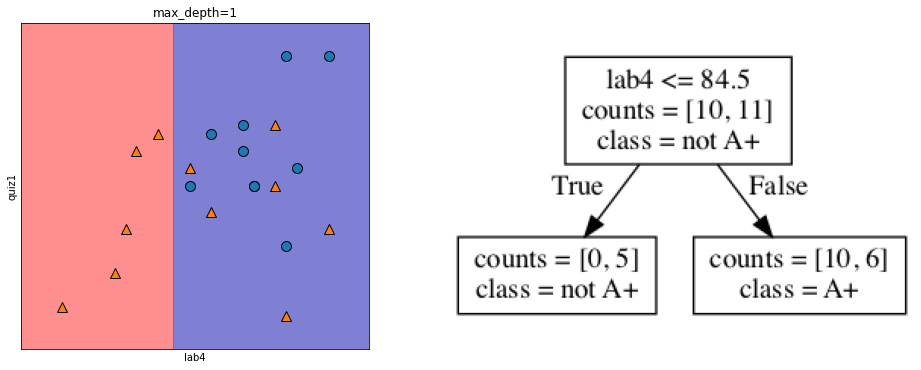

In [5]:
depth = 1
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
model.score(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

In the following model, this decision boundary is created by asking two questions. 

Error:   0.190


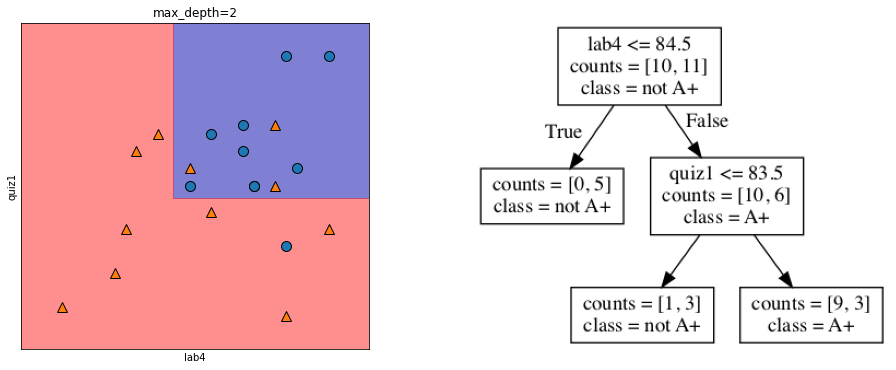

In [6]:
depth = 2
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
model.score(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

Let's look at the decision boundary with depth = 4. 

Error:   0.048


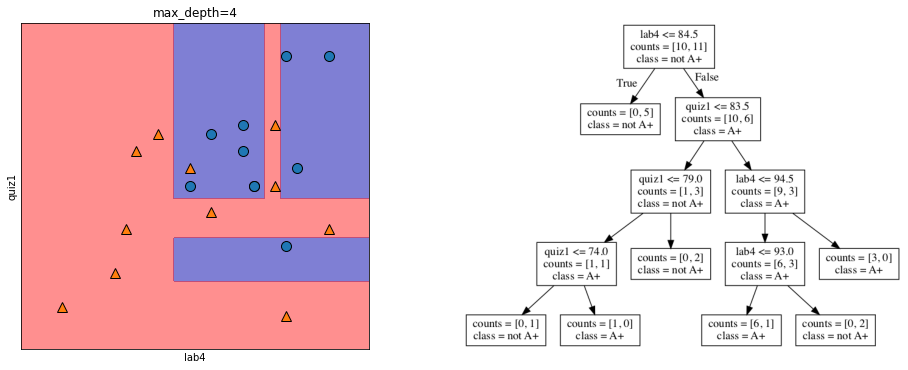

In [7]:
depth = 4
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
model.score(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

Let's look at the decision boundary with depth = 6. 

Error:   0.000


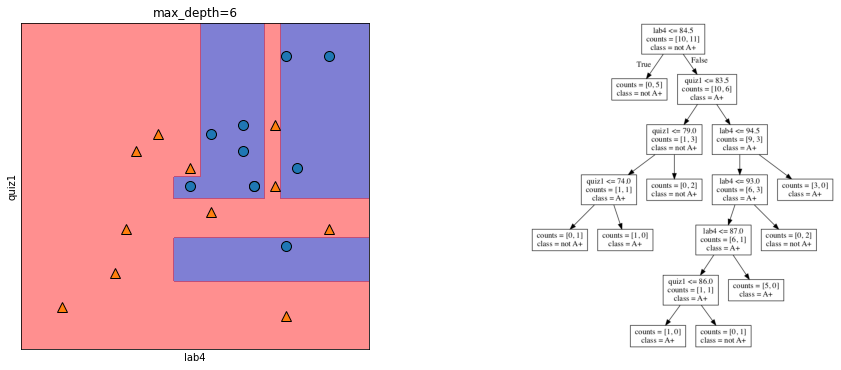

In [8]:
depth = 6
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
model.score(X_subset, y)
print("Error:   %0.3f" % (1 - model.score(X_subset, y)))
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

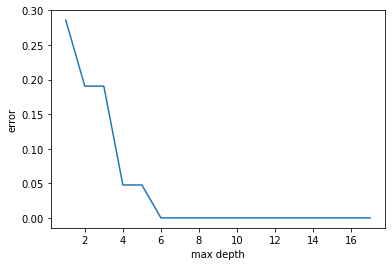

In [9]:
max_depths = np.arange(1, 18)
errors = []
for max_depth in max_depths:
    error = 1 - DecisionTreeClassifier(max_depth=max_depth).fit(X_subset, y).score(X_subset, y)
    errors.append(error)
plt.plot(max_depths, errors);
plt.xlabel("max depth");
plt.ylabel("error");

- Our model has 0% error for depths >= 6!! 
- But it's also becoming more and more specific and sensitive to the training data.  
- Is it good or bad?

### 🤔 Eva's questions

![](img/eva-think.png)


At this point Eva is wondering about the following questions. 

- How to pick the best depth? 
- How can we make sure that the model we have built would do reasonably well on new data in the wild when it's deployed? 
- Which of the following rules learned by the decision tree algorithm are likely to generalize better to new data? 

> Rule 1: If class_attendance == 1 then grade is A+. 

> Rule 2: If lab3 > 83.5 and quiz1 <= 83.5 and lab2 <= 88 then quiz2 grade is A+

To better understand the material in the next sections, think about these questions on your own or discuss them with your friend/neighbour before proceeding. 

<br><br><br><br>

### Generalization: Fundamental goal of ML

> **To generalize beyond what we see in the training examples**

We only have access to limited amount of training data and we want to learn a mapping function which would predict targets reasonably well for examples beyond this training data. 

- Example: Imagine that a learner sees the following images and corresponding labels. 

![](img/generalization-train.png)
<!-- <center>
<img src='img/generalization-train.png' width="600" height="600" />
</center>     -->

### Generalizing to unseen data

- Now the learner is presented with new images (1 to 4) for prediction. 
- What prediction would you expect for each image?   

![](img/generalization-predict.png)

<!-- <center>
<img src='img/generalization-predict.png' width="1000" height="1000" />
</center>     -->

- Goal: We want the learner to be able to generalize beyond what it has seen in the training data.
- But these new examples should be representative of the training data. That is they should have the same characteristics as the training data. 
- In this example, we would like the leaner to be able to predict labels for test examples 1, 2, and 3 accurately. Although 2, 3 don't exactly occur in the training data, they are very much similar to the images in the training data. That said, is it fair to expect the learner to label image 4 correctly? 

### Training error vs. Generalization error 

- Given a model $M$, in ML, people usually talk about two kinds of errors of $M$. 
    1. Error on the training data: $error_{training}(M)$ 
    2. Error on the entire distribution $D$ of data: $error_{D}(M)$
- We are interested in the error on the entire distribution     
    - ... But we do not have access to the entire distribution 😞

<br><br><br><br>

## Data Splitting 

### How to approximate generalization error? 

A common way is **data splitting**. 
- Keep aside some randomly selected portion from the training data.
- `fit` (train) a model on the training portion only. 
- `score` (assess) the trained model on this set aside data to get a sense of how well the model would be able to generalize.
- Pretend that the kept aside data is representative of the real distribution $D$ of data. 

![](img/eva-good-idea.png)

In [10]:
# scikit-learn train_test_split
url = "https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"
HTML("<iframe src=%s width=1000 height=800></iframe>" % url)

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


- We can pass `X` and `y` or a dataframe with both `X` and `y` in it. 
- We can also specify the train or test split sizes. 

### Simple train/test split 

- The picture shows an 80%-20% split of a toy dataset with 10 examples. 
- The data is shuffled before splitting. 
- Usually when we do machine learning we split the data before doing anything and put the test data in an imaginary chest lock. 

![](img/train-test-split.png)

<!-- <img src='img/train-test-split.png' width="1500" height="1500" /> -->

In [11]:
# Let's demonstrate this with the canada usa cities data
# The data is available in the data directory
df = pd.read_csv("data/canada_usa_cities.csv")
X = df.drop(columns=["country"])
y = df["country"]

In [12]:
X

,longitude,latitude
0,-130.0437,55.9773
1,-134.4197,58.3019
2,-123.0780,48.9854
3,-122.7436,48.9881
4,-122.2691,48.9951
...,...,...
204,-72.7218,45.3990
205,-66.6458,45.9664
206,-79.2506,42.9931
207,-72.9406,45.6275


In [13]:
y

0         USA
1         USA
2         USA
3         USA
4         USA
        ...  
204    Canada
205    Canada
206    Canada
207    Canada
208    Canada
Name: country, Length: 209, dtype: object

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)  # 80%-20% train test split on X and y

# Print shapes
shape_dict = {
    "Data portion": ["X", "y", "X_train", "y_train", "X_test", "y_test"],
    "Shape": [
        X.shape,
        y.shape,
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
    ],
}

shape_df = pd.DataFrame(shape_dict)
HTML(shape_df.to_html(index=False))

Data portion,Shape
X,"(209, 2)"
y,"(209,)"
X_train,"(167, 2)"
y_train,"(167,)"
X_test,"(42, 2)"
y_test,"(42,)"


#### Creating `train_df` and `test_df`

- Sometimes we want to keep the target in the train split for EDA or for visualization. 

In [15]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=123
)  # 80%-20% train test split on df
X_train, y_train = train_df.drop(columns=["country"]), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"]), test_df["country"]
train_df.head()

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada


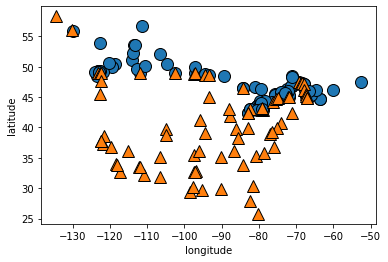

In [16]:
mglearn.discrete_scatter(X.iloc[:, 0], X.iloc[:, 1], y, s=12)
plt.xlabel("longitude")
plt.ylabel("latitude");

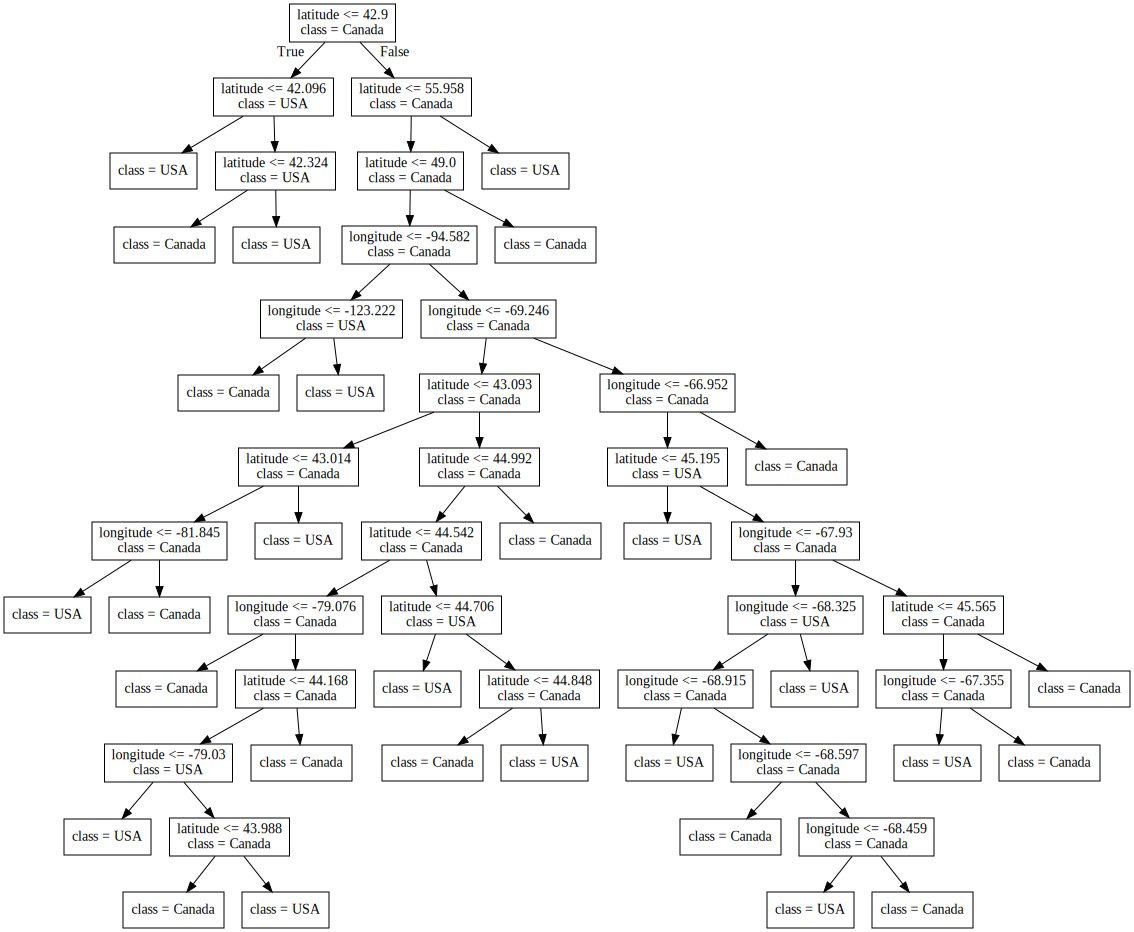

In [17]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
display_tree(X_train.columns, model)

Let's examine the train and test accuracies with the split now.

In [18]:
print("Train accuracy:   %0.3f" % model.score(X_train, y_train))
print("Test accuracy:   %0.3f" % model.score(X_test, y_test))

Train accuracy:   1.000
Test accuracy:   0.738


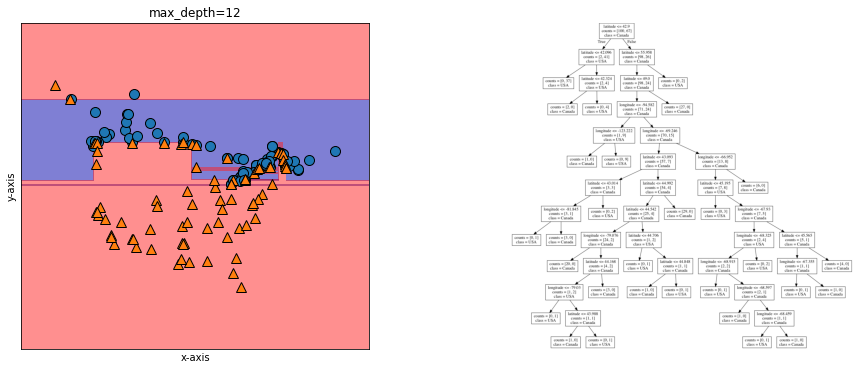

In [19]:
plot_tree_decision_boundary_and_tree(model, X, y, height=6, width=16, eps=10)

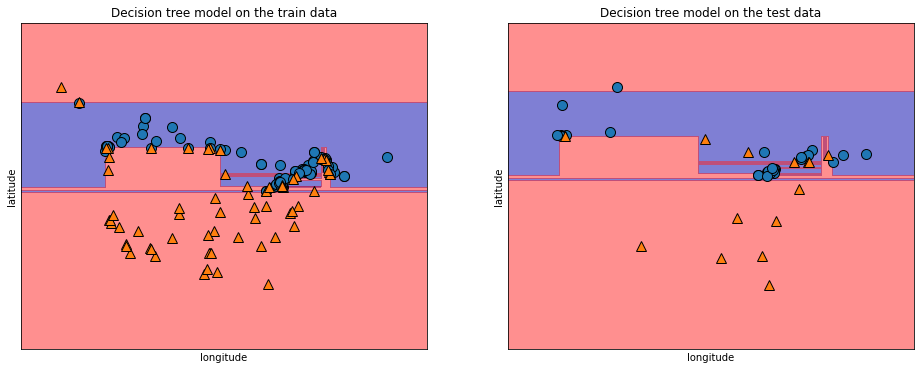

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={"xticks": (), "yticks": ()})
plot_tree_decision_boundary(
    model,
    X_train,
    y_train,
    eps=10,
    x_label="longitude",
    y_label="latitude",
    ax=ax[0],
    title="Decision tree model on the train data",
)
plot_tree_decision_boundary(
    model,
    X_test,
    y_test,
    eps=10,
    x_label="longitude",
    y_label="latitude",
    ax=ax[1],
    title="Decision tree model on the test data",
)

- Useful arguments of `train_test_split`: 
    - `test_size`
    - `train_size` 
    - `random_state`

#### `test_size`, `train_size` arguments

- Let's us specify how we want to split the data. 
- We can specify either of the two. See the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
- There is no hard and fast rule on what split sizes should we use. 
    - It depends upon how much data is available to you. 
- Some common splits are 90/10, 80/20, 70/30 (training/test).
- In the above example, we used 80/20 split. 

#### `random_state` argument

- The data is shuffled before splitting which is crucial step. (You will explore this in the lab.) 
- The `random_state` argument controls this shuffling. 
- In the example above we used `random_state=123`. If you run this notebook with the same `random_state` it should give you exactly the same split. 
    - Useful when you want reproducible results. 

### Train/validation/test split

- Some of you may have heard of "validation" data.
- Sometimes it's a good idea to have a separate data for hyperparameter tuning. 

![](img/train-valid-test-split.png)

<!-- <img src='img/train-valid-test-split.png' width="1500" height="1500" /> -->

- We will try to use "validation" to refer to data where we have access to the target values.
  - But, unlike the training data, we only use this for hyperparameter tuning and model assessment; we don't pass these into `fit`.  
- We will try to use "test" to refer to data where we have access to the target values 
  - But, unlike training and validation data, we neither use it in training nor hyperparameter optimization. 
  - We only use it **once** to evaluate the performance of the best performing model on the validation set.   
  - We lock it in a "vault" until we're ready to evaluate. 

Note that there isn't good concensus on the terminology of what is validation and what is test. 

```{admonition} Note 
:class: note
Validation data is also referred to as **development data** or **dev set** for short.  
```

### "Deployment" data

- After we build and finalize a model, we deploy it, and then the model deals with the data in the wild. 
- We will use "deployment" to refer to this data, where we do **not** have access to the target values.
- Deployment error is what we _really_ care about.
- We use validation and test errors as proxies for deployment error, and we hope they are similar.
- So, if our model does well on the validation and test data, we hope it will do well on deployment data.

### Summary of train, validation, test, and deployment data

|         | `fit` | `score` | `predict` |
|----------|-------|---------|-----------|
| Train    | ✔️      | ✔️      | ✔️         |
| Validation |      | ✔️      | ✔️         |
| Test    |       |  once   | once         |
| Deployment    |       |       | ✔️         |

You can typically expect $E_{train} < E_{validation} < E_{test} < E_{deployment}$.

<br><br><br><br>

## Cross-validation

### Problems with single train/validation split

- Only using a portion of your data for training and only a portion for validation.
- If your dataset is small you might end up with a tiny training and/or validation set.
- You might be unlucky with your splits such that they don't align well or don't well represent your test data.

![](img/train-valid-test-split.png)

<!-- <img src='img/train-valid-test-split.png' width="1500" height="1500" /> -->

### Cross-validation to the rescue!! 

- Cross-validation provides a solution to this problem. 
- Split the data into $k$ folds ($k>2$, often $k=10$). In the picture below $k=4$.
- Each "fold" gets a turn at being the validation set.
- Note that cross-validation doesn't shuffle the data; it's done in `train_test_split`.

![](img/cross-validation.png)
<!-- <img src='img/cross-validation.png' width="1500"> -->

- Each fold gives a score and we usually average our $k$ results. 
- It's better to examine the variation in the scores across folds.  
- Gives a more **robust** measure of error on unseen data.

### Cross-validation using `scikit-learn`

In [21]:
from sklearn.model_selection import cross_val_score, cross_validate

#### `cross_val_score`

In [22]:
model = DecisionTreeClassifier(max_depth=4)
cv_scores = cross_val_score(model, X_train, y_train, cv=10)
cv_scores

array([0.76470588, 0.82352941, 0.70588235, 0.94117647, 0.82352941,
       0.82352941, 0.70588235, 0.9375    , 0.9375    , 0.9375    ])

In [23]:
print(f"Average cross-validation score = {np.mean(cv_scores):.2f}")
print(f"Standard deviation of cross-validation score = {np.std(cv_scores):.2f}")

Average cross-validation score = 0.84
Standard deviation of cross-validation score = 0.09


Under the hood

- It creates `cv` folds on the data.
- In each fold, it fits the model on the training portion and scores on the validation portion. 
- The output is a list of validation scores in each fold.

#### `cross_validate`

- Similar to `cross_val_score` but more powerful.
- Let's us access training and validation scores.  

In [24]:
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001755,0.000907,0.764706,0.913333
1,0.001570,0.001009,0.823529,0.906667
2,0.001217,0.000791,0.705882,0.906667
3,0.001203,0.000843,0.941176,0.900000
4,0.001549,0.000835,0.823529,0.906667
5,0.001430,0.001203,0.823529,0.913333
6,0.001381,0.000876,0.705882,0.920000
7,0.001215,0.000806,0.937500,0.900662
8,0.001261,0.001127,0.937500,0.900662
9,0.001214,0.000812,0.937500,0.900662


In [25]:
pd.DataFrame(pd.DataFrame(scores).mean())

,0
fit_time,0.001379
score_time,0.000921
test_score,0.840074
train_score,0.906865


```{important}
Keep in mind that cross-validation does not return a model. It is not a way to build a model that can be applied to new data. The purpose of cross-validation is to **evaluate** how well the model will generalize to unseen data. 
```

```{seealso}
Note that both `cross_val_score` and `cross_validate` functions do not shuffle the data. Check out [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), where proportions of classes is the same in each fold as they are in the whole dataset. By default, `sklearn` uses `StratifiedKFold` when carrying out cross-validation for classification problems. 
```

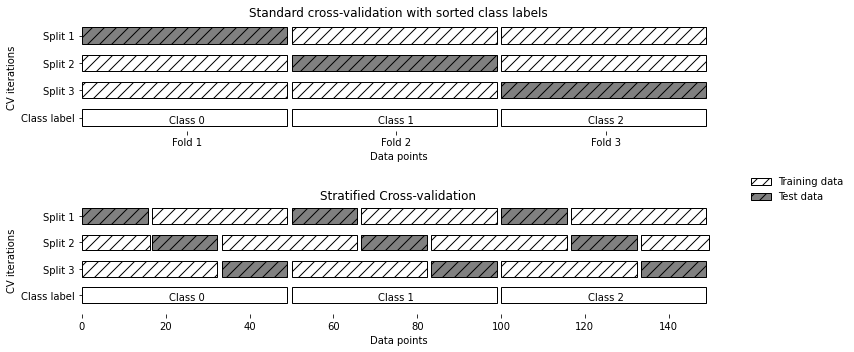

In [26]:
mglearn.plots.plot_stratified_cross_validation()

### ❓❓ Questions on cross-validation

```{admonition} Exercise 3.1: Cross-validation

1. $k$-fold cross-validation calls fit $k$ times and predict $k$ times.
2. We carry out cross-validation to avoid reusing the same validation set again and again. With $k$-fold cross-validation, you split your $n$ examples into $k$ folds. For each fold, you train on __ examples 
        1. n
        2. n/k
        3. n - n/k  or n(k-1)/k
        4. k 
        
3. With $k$-fold cross-validation, you split your $n$ examples into $k$ folds. For each fold, when you are done, you add up the accuracies from each fold and divide by __
        1. n
        2. n/k
        3. n - n/k or n(k-1)/k
        4. k    
4. What do you think are the advantages and disadvantages of cross-validation?         
```

```{admonition} Exercise 3.1: Solutions!
:class: tip, dropdown
TBD
```

#### Our typical supervised learning set up is as follows: 

- We are given training data with features `X` and target `y`
- We split the data into train and test portions: `X_train, y_train, X_test, y_test`
- We carry out hyperparameter optimization using cross-validation on the train portion: `X_train` and `y_train`. 
- We assess our best performing model on the test portion: `X_test` and `y_test`.  
- What we care about is the **test error**, which tells us how well our model can be generalized.
- If this test error is "reasonable" we deploy the model which will be used on new unseen examples.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = DecisionTreeClassifier(max_depth=10)
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.001863,0.001284,0.937500,1.000000
1,0.001282,0.000810,0.875000,0.992857
2,0.001178,0.000871,0.875000,1.000000
3,0.001717,0.000894,0.687500,1.000000
4,0.001340,0.000804,0.812500,1.000000
5,0.001203,0.000812,0.812500,1.000000
6,0.001760,0.000886,0.866667,0.985816
7,0.001550,0.000895,0.600000,0.992908
8,0.001307,0.001042,0.666667,1.000000
9,0.001152,0.000808,0.733333,1.000000


In [28]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [29]:
results = {}
results["Decision tree"] = mean_std_cross_val_scores(model, X_train, y_train, return_train_score=True)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Decision tree,0.001 (+/- 0.000),0.001 (+/- 0.000),0.788 (+/- 0.055),0.992 (+/- 0.014)


In [1]:
### ❓❓ Questions for you

- How do we know whether this test score is reasonable? 

<br><br><br><br>

## Underfitting, overfitting, the fundamental trade-off, the golden rule

### Types of errors

Imagine that your train and validation errors do not align with each other. How do you diagnose the problem?  

We're going to think about 4 types of errors:

- $E_\textrm{train}$ is your training error (or mean train error from cross-validation).
- $E_\textrm{valid}$ is your validation error (or mean validation error from cross-validation).
- $E_\textrm{test}$ is your test error.
- $E_\textrm{best}$ is the best possible error you could get for a given problem.

### Underfitting 

In [31]:
model = DecisionTreeClassifier(max_depth=1) # decision stump
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
print("Train error:   %0.3f" % (1 - np.mean(scores["train_score"])))
print("Validation error:   %0.3f" % (1 - np.mean(scores["test_score"])))

Train error:   0.188
Validation error:   0.212


- If your model is too simple, like `DummyClassifier` or `DecisionTreeClassifier` with `max_depth=1`, it's not going to pick up on some random quirks in the data but it won't even capture useful patterns in the training data.
- The model won't be very good in general. Both train and validation errors would be high. This is **underfitting**.
- The gap between train and validation error is going to be lower.
- $E_\textrm{best} \lt E_\textrm{train} \lesssim E_\textrm{valid}$

### Overfitting 

In [32]:
model = DecisionTreeClassifier(max_depth=None) 
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
print("Train error:   %0.3f" % (1 - np.mean(scores["train_score"])))
print("Validation error:   %0.3f" % (1 - np.mean(scores["test_score"])))

Train error:   0.000
Validation error:   0.220


- If your model is very complex, like a `DecisionTreeClassifier(max_depth=None)`, then you will learn unreliable patterns in order to get every single training example correct.
- The training error is going to be very low but there will be a big gap between the training error and the validation error. This is **overfitting**.
- In overfitting scenario, usually we'll see: 
$E_\textrm{train} \lt E_\textrm{best}  \lt E_\textrm{valid}$
- In general, if $E_\textrm{train}$ is low, we are likely to be in the overfitting scenario. It is fairly common to have at least a bit of this.

- So the validation error does not necessarily decrease with the training error. 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
results_dict = {
    "depth": [],
    "mean_train_error": [],
    "mean_cv_error": [],
    "std_cv_error": [],
    "std_train_error": [],
}
param_grid = {"max_depth": np.arange(1, 16)}

for depth in param_grid["max_depth"]:
    model = DecisionTreeClassifier(max_depth=depth)
    scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    results_dict["depth"].append(depth)
    results_dict["mean_cv_error"].append(1 - np.mean(scores["test_score"]))
    results_dict["mean_train_error"].append(1- np.mean(scores["train_score"]))
    results_dict["std_cv_error"].append(scores["test_score"].std())
    results_dict["std_train_error"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)
results_df = results_df.set_index("depth")

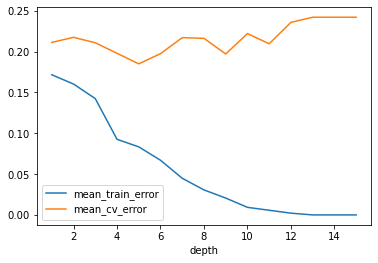

In [34]:
results_df[["mean_train_error", "mean_cv_error"]].plot();

- Here, for larger depths we observe that the training error is close to 0 but validation error goes up and down. 
- As we make more complex models we start encoding random quirks in the data, which are not grounded in reality.  
- These random quirks do not generalize well to new data. 
- This problem of failing to be able to generalize to the validation data or test data is called **overfitting**.

### The "fundamental tradeoff" of supervised learning:


**As you increase model complexity, $E_\textrm{train}$ tends to go down but $E_\textrm{valid}-E_\textrm{train}$ tends to go up.**


### Bias vs variance tradeoff 

- The fundamental trade-off is also called the bias/variance tradeoff in supervised machine learning.

**Bias**
: the tendency to consistently learn the same wrong thing (high bias corresponds to underfitting)

**Variance** 
: the tendency to learn random things irrespective of the real signal (high variance corresponds to overfitting)

```{seealso} 
Check out [this article by Pedro Domingos](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) for some approachable explanation on machine learning fundamentals and bias-variance tradeoff. 
```

### ❓❓ Questions for you

```{admonition} Exercise 3.3

Underfitting or overfitting? 
1. If the mean train accuracy is much higher than the mean cross-validation accuracy.
2. If the mean train accuracy and the mean cross-validation accuracy are both low and relatively similar in value.
3. Decision tree with no limit on the depth. 
4. Decision stump on a complicated classification problem. 
```

```{admonition} Exercise 3.3: Solutions!
:class: tip, dropdown
TBD
```

```{admonition} Exercise 3.4
 
State whether True/False. 

1. In supervised learning, the training error is always lower than the validation error.
2. The fundamental tradeoff of ML states that as training error goes down, validation error goes up.
3. More "complicated" models are more likely to overfit than "simple" ones.
4. If we had an infinite amount of training data, overfitting would not be a problem.
5. If our training error is extremely low, that means we're overfitting.
```

```{admonition} Exercise 3.4: Solutions!
:class: tip, dropdown
TBD
```

### How to pick a model that would generalize better?

- We want to avoid both underfitting and overfitting. 
- We want to be consistent with the training data but we don't to rely too much on it. 

<!-- <center>
<img src='img/malp_0201.png' width="800" height="800" />
</center>    
 -->
![](img/malp_0201.png)

[source](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch02.html#relation-of-model-complexity-to-dataset-size)

- There are many subtleties here and there is no perfect answer but a  common practice is to pick the model with minimum cross-validation error. 

In [35]:
def cross_validate_std(*args, **kwargs):
    """Like cross_validate, except also gives the standard deviation of the score"""
    res = pd.DataFrame(cross_validate(*args, **kwargs))
    res_mean = res.mean()
    res_mean["std_test_score"] = res["test_score"].std()
    if "train_score" in res:
        res_mean["std_train_score"] = res["train_score"].std()
    return res_mean

In [36]:
results_df

,mean_train_error,mean_cv_error,std_cv_error,std_train_error
depth,,,,
1,0.171657,0.211250,0.048378,0.006805
2,0.160258,0.217500,0.048940,0.007316
3,0.142467,0.210833,0.067757,0.022848
4,0.092604,0.197917,0.056955,0.006531
5,0.083338,0.185000,0.064205,0.010650
6,0.066960,0.197500,0.074773,0.012065
7,0.044873,0.217083,0.080847,0.009059
8,0.030618,0.216250,0.088397,0.010547
9,0.020653,0.197083,0.093950,0.010294


### test score vs. cross-validation score

In [37]:
best_depth = results_df.index.values[np.argmin(results_df["mean_cv_error"])]
print(
    "The minimum validation error is %0.3f at max_depth = %d "
    % (
        np.min(results_df["mean_cv_error"]),
        best_depth,
    )
)

The minimum validation error is 0.185 at max_depth = 5 


- Let's pick `max_depth`= 5 and try this model on the test set. 

In [38]:
model = DecisionTreeClassifier(max_depth=best_depth)
model.fit(X_train, y_train)
print(f"Error on test set: {1 - model.score(X_test, y_test):.2f}")

Error on test set: 0.19


- The test error is comparable with the cross-validation error. 
- Do we feel confident that this model would give similar performace when deployed? 

### The golden rule <a name="4"></a>

- Even though we care the most about test error **THE TEST DATA CANNOT INFLUENCE THE TRAINING PHASE IN ANY WAY**. 
- We have to be very careful not to violate it while developing our ML pipeline. 
- Even experts end up breaking it sometimes which leads to misleading results and lack of generalization on the real data. 

#### Golden rule violation: Example 1  

![](img/golden_rule_violation.png)

<!-- <center>
<img src='img/golden_rule_violation.png' width="500" height="500" />
</center>    
 -->
 
<blockquote>
   ... He attempted to reproduce the research, and found a major flaw: there was some overlap in the data used to both train and test the model. 
</blockquote>    

#### Golden rule violation: Example 2  

<!-- <center>
<img src='img/golden_rule_violation_2.png' width="500" height="500" />
</center>    
 -->
 
![](img/golden_rule_violation_2.png)

<blockquote>
  ... The Challenge rules state that you must only test your code twice a week, because there’s an element of chance to the results. Baidu has admitted that it used multiple email accounts to test its code roughly 200 times in just under six months – over four times what the rules allow.
</blockquote>


### How can we avoid violating golden rule? 

- Recall that when we split data, we put our test set in an imaginary vault.

<!-- <center>
<img src='img/train-test-split.png' width="1500" height="1500" />
</center>    
 -->
 
![](img/train-test-split.png)

### Here is the workflow we'll generally follow. 

- **Splitting**: Before doing anything, split the data `X` and `y` into `X_train`, `X_test`, `y_train`, `y_test` or `train_df` and `test_df` using `train_test_split`. 
- **Select the best model using cross-validation**: Use `cross_validate` with `return_train_score = True` so that we can get access to training scores in each fold. (If we want to plot train vs validation error plots, for instance.) 
- **Scoring on test data**: Finally score on the test data with the chosen hyperparameters to examine the generalization performance.

**Again, there are many subtleties here we'll discuss the golden rule multiple times throughout the course and in the program.**  

<br><br><br><br>

## What did we learn today? 

- Importance of generalization in supervised machine learning. 
- Data splitting as a way to approximate generalization error. 
- Train, test, validation, deployment data
- Cross-validation
- A typical sequence of steps to train supervised machine learning models. 
    - training the model on the train split
    - tuning hyperparamters using the validation split
    - checking the generalization performance on the test split. 
- Overfitting, underfitting,  

### Coming up ...  

- KNNs, SVM RBFs 
- Preprocessing
    - Imputation
    - Scaling
    - One-hot encoding
    - `sklearn` pipelines

![](img/eva-seeyou.png)
